The following figure shows how to use different statistical methods to make A/B testing successful based on the metrics, sample size, and sampling distributions of the data.

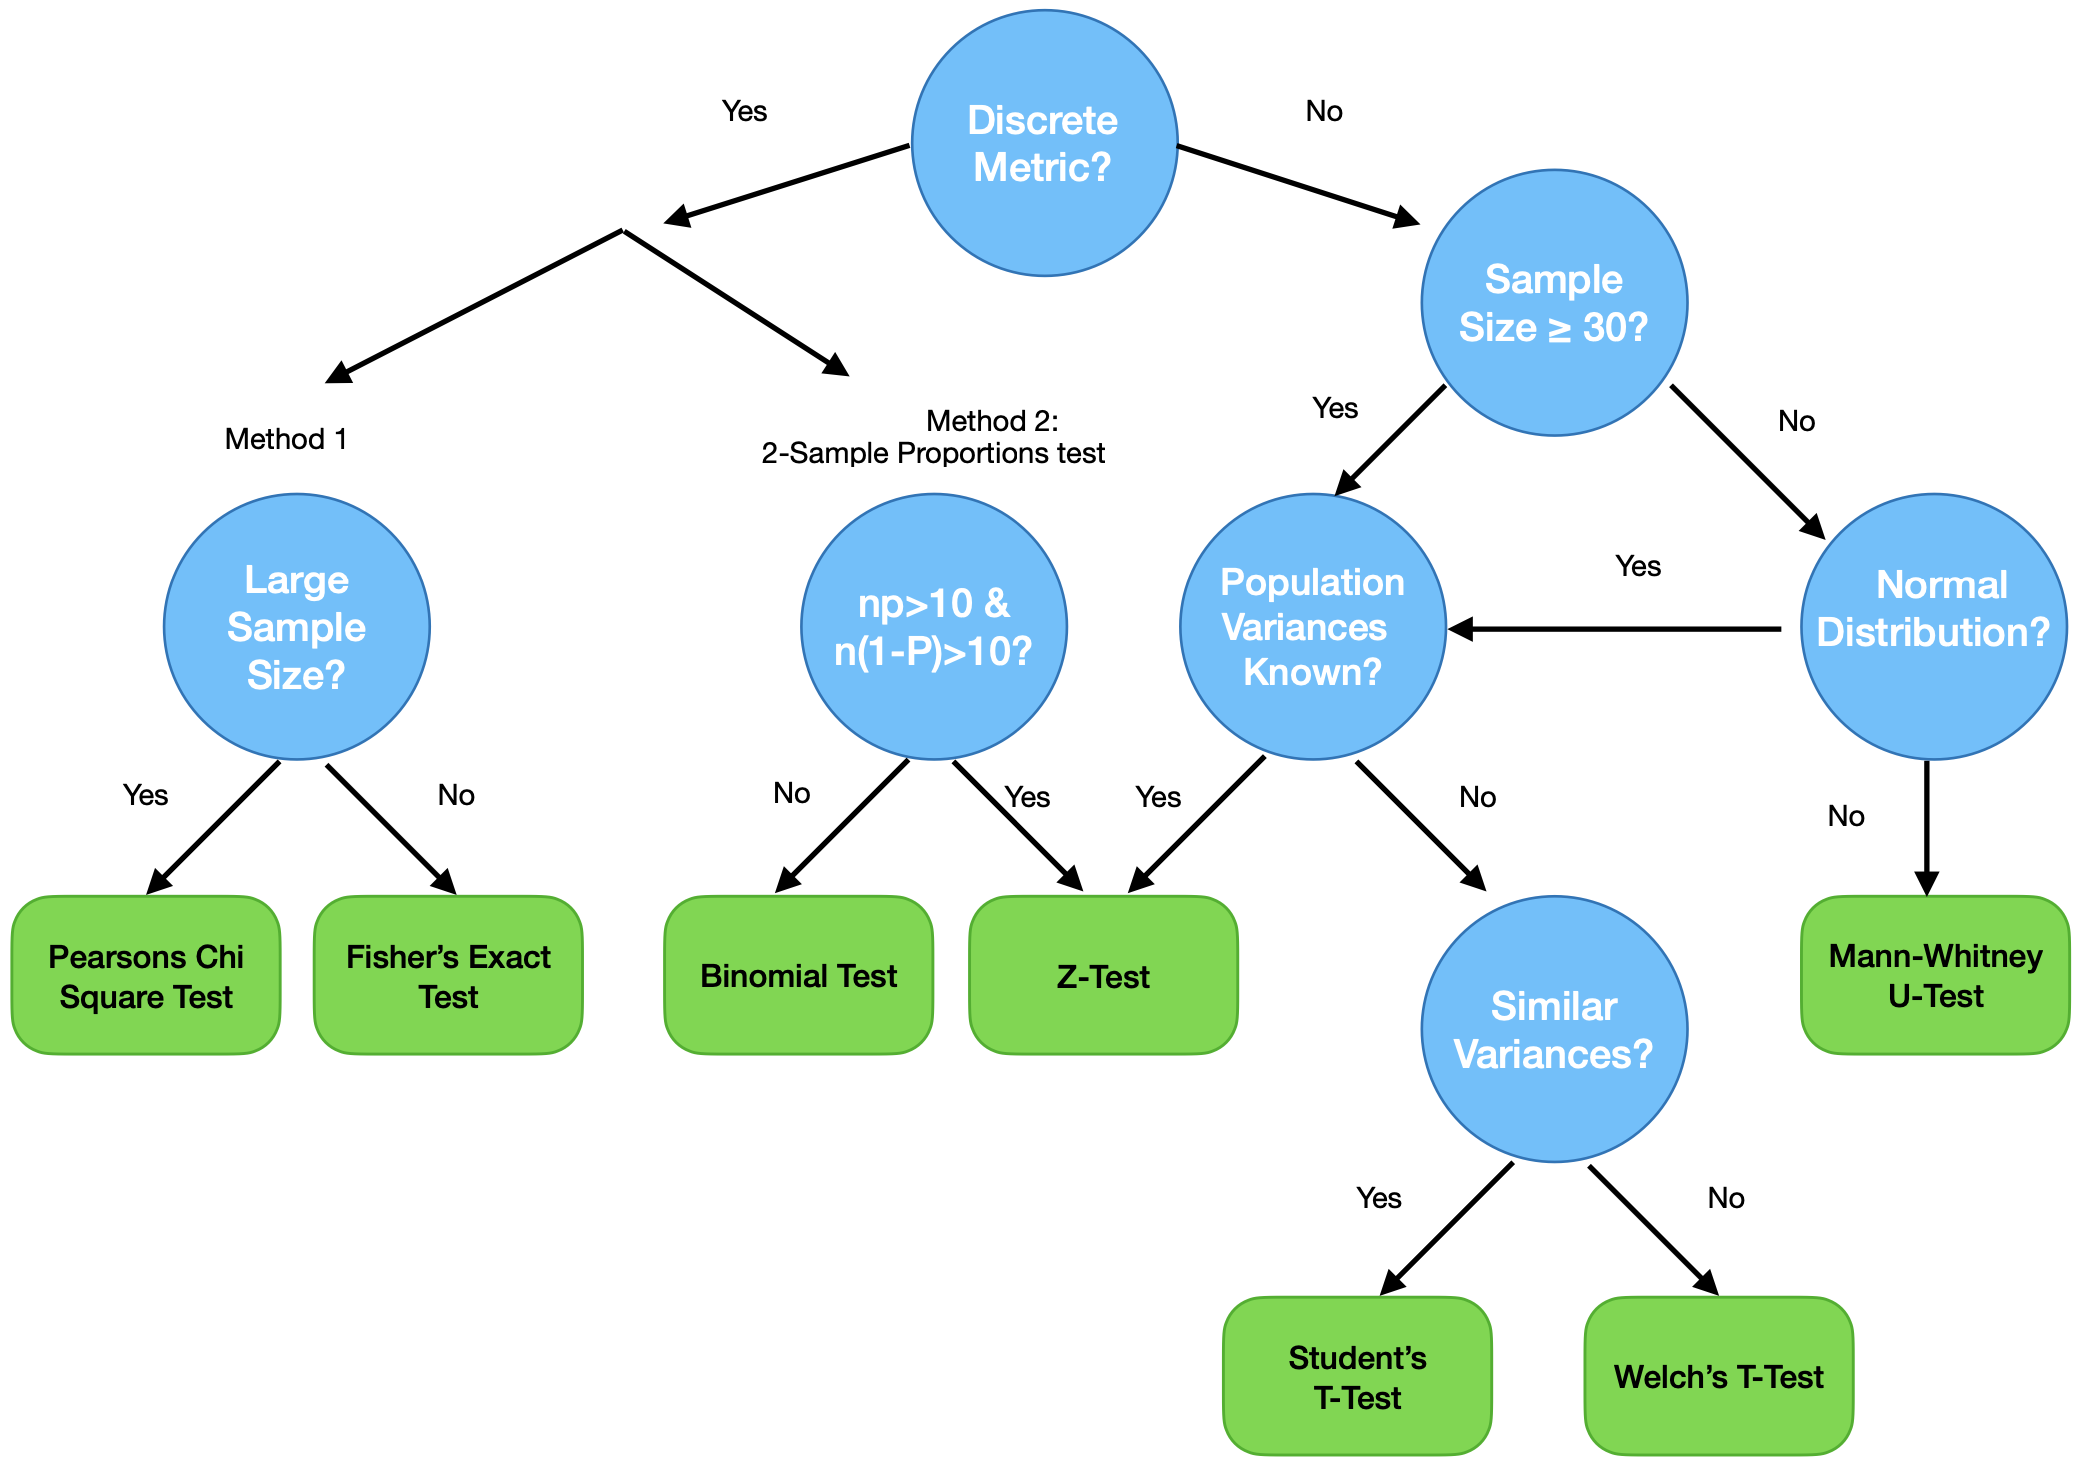

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from numpy import percentile

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import shapiro

import pingouin as pg

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

### 1. A/B testing on Discrete metrics

In [2]:
df = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/A:B Testing/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# Check for duplicated rows
dupplicated = df.duplicated()
print(dupplicated.any())

False


In [5]:
# Check for user_id repeated visits
repeated_user_id = df[df['user_id'].duplicated()]

In [6]:
repeated_user_id.shape

(3894, 5)

In [7]:
repeated_user_id.value_counts()

user_id  timestamp                   group      landing_page  converted
630052   2017-01-17 01:16:05.208766  treatment  new_page      0            1
838769   2017-01-20 16:57:58.245061  control    new_page      0            1
835675   2017-01-09 08:08:15.033939  control    new_page      0            1
835782   2017-01-08 12:18:21.247646  treatment  old_page      0            1
835788   2017-01-19 08:27:03.964337  control    old_page      0            1
                                                                          ..
733739   2017-01-16 13:45:37.051528  treatment  old_page      0            1
733794   2017-01-04 06:59:59.284472  treatment  new_page      0            1
733888   2017-01-21 00:40:41.792130  treatment  old_page      0            1
733972   2017-01-09 15:38:08.424351  control    old_page      1            1
945971   2017-01-16 10:09:18.383183  control    old_page      0            1
Name: count, Length: 3894, dtype: int64

In [8]:
repeated_pct = repeated_user_id.shape[0] / df.shape[0] * 100
print(f"The percent of users that visited our site more than once is {repeated_pct:.2f}%")

The percent of users that visited our site more than once is 1.32%


In [9]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Check if there is mismatch between group and landing_page
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mismatch = df_mismatch.shape[0]
print(f"The number of mismatched rows: {n_mismatch} rows" )
print("Percent of mismatched rows: %.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32%


In [11]:
# Removing the mismatched data
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
                |(df["group"]=="control")&(df["landing_page"]=="old_page")]

In [12]:
# Check for user_id repeated visits
repeated_user_id2 = df2[df2['user_id'].duplicated()]

In [13]:
# Re-checking if there are any user_id's that revisited our site after removing mismatched columns from above
repeated_user_id2.shape[0]

1

In [14]:
df2.shape[0]

290585

In [15]:
df2.drop_duplicates(subset="user_id",inplace=True) 

In [16]:
df2.shape[0]

290584

In [17]:
# Conversion Rate
df_counts = pd.DataFrame({"Control_COUNT": df2[df2.group=="control"].converted.value_counts(),
              "Treatment_COUNT": df2[df2.group=="treatment"].converted.value_counts(),
              "Control_RATIO": df2[df2.group=="control"].converted.value_counts()/ len(df2[df2.group=="control"]),
              "Trement_RATIO": df2[df2.group=="treatment"].converted.value_counts() / len(df2[df2.group=="treatment"])})

In [18]:
df_counts

,Control_COUNT,Treatment_COUNT,Control_RATIO,Trement_RATIO
converted,,,,
0,127785,128046,0.879614,0.881192
1,17489,17264,0.120386,0.118808


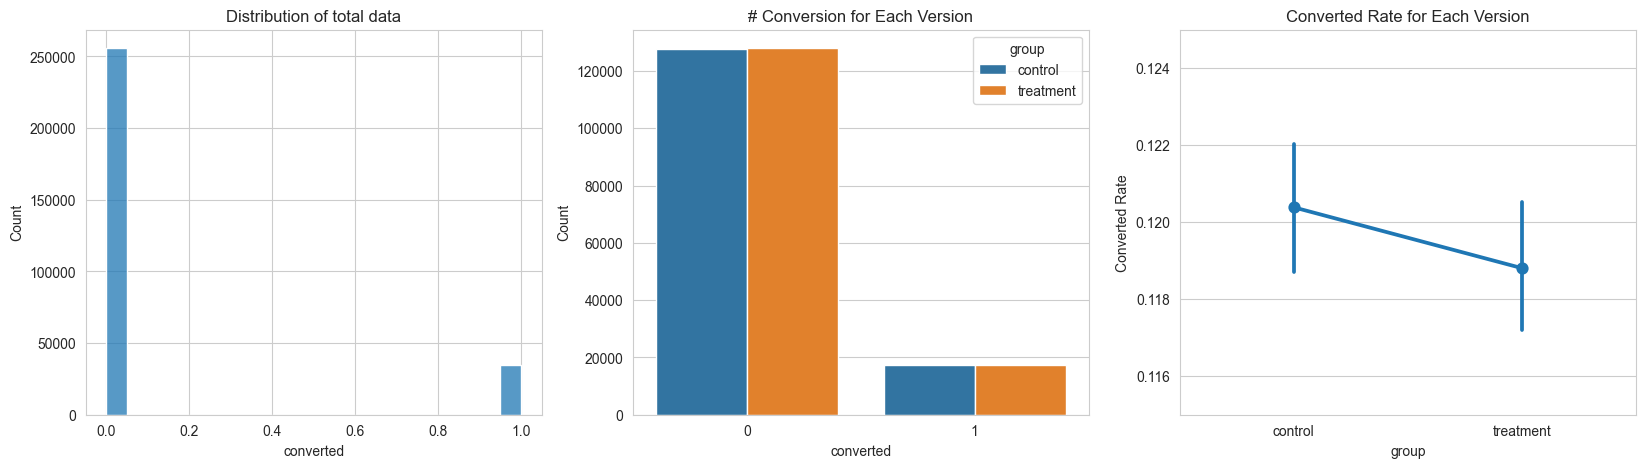

In [19]:
fig, axes = plt.subplots(1,3)

sns.histplot(x="converted", data=df2, ax=axes[0])
axes[0].set_title("Distribution of total data")

sns.countplot(x="converted", data=df2, hue="group", ax=axes[1])
axes[1].set(title="# Conversion for Each Version", ylabel="Count")

sns.pointplot(x="group", y="converted", data=df2, ax=axes[2])
axes[2].set_ylim([0.115, 0.125])
axes[2].set(title="Converted Rate for Each Version", ylabel="Converted Rate")

plt.show()

- The Conversion number is a discrete metric, with only 0 or 1 value, the sample size of the data is large, so Pearson's chi-square test is much better to be applied.

- The conversion rate of the new version is slightly lower than that of the old version, but there is some overlap between the two versions, so the difference doesn't look significant.

### Statistical Anaysis

- Null Hypothesis (H0): The conversion rate of the control version is equal to the conversion rate of the treatment version.
- Alternative Hypothesis (H1): The conversion rate of the control version is not equal to the conversion rate of the treatment version.
  

 
The **Null Hypothesis (H0)** assumes that there is no difference in conversion rates between the control and treatment groups. This means any observed difference in conversion rates is due to random chance.

The **Alternative Hypothesis (H1)** assumes that there is a difference in conversion rates between the control and treatment groups. This means that the observed difference is statistically significant and not due to random chance.

In [20]:
table = df_counts.iloc[:,0:2].to_numpy()
table

array([[127785, 128046],
       [ 17489,  17264]])

In [21]:
# chi-squared test 
stat, p, dof, expected = stats.chi2_contingency(table)

print(f"Degrees of freedom = {dof}")
print("Expected frequencies:")
print(expected)
print('-' * 70)

# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print(f'Probability = {prob:.3f}, Critical value = {critical:.3f}, Test statistic = {stat:.3f}')
print('-' * 70)

if abs(stat) >= critical:
    print('Dependent (reject Null Hypothesis (H0))')
else:
    print('Independent (fail to reject Null Hypothesis (H0))')

# interpret p-value
alpha = 1 - prob
print(f'Significance level = {alpha:.3f}, p-value = {p:.3f}')
if p <= alpha:
    print('Dependent (reject Null Hypothesis (H0))')
else:
    print('Independent (fail to reject Null Hypothesis (H0))')


Degrees of freedom = 1
Expected frequencies:
[[127899.65274757 127931.34725243]
 [ 17374.34725243  17378.65274757]]
----------------------------------------------------------------------
Probability = 0.950, Critical value = 3.841, Test statistic = 1.704
----------------------------------------------------------------------
Independent (fail to reject Null Hypothesis (H0))
Significance level = 0.050, p-value = 0.192
Independent (fail to reject Null Hypothesis (H0))


- Since the test statistic (1.704) is less than the critical value (3.841), we fail to reject the null hypothesis, suggesting that the variables are independent.


- Since the p-value (0.192) is greater than the significance level (0.050), we fail to reject the null hypothesis, indicating that there is no significant association between the variables.

We can also try using Fisher's exact test despite that we have a large dataset

In [22]:
# Fishers exact test

# Set the significance level
alpha = 0.05

# Perform Fisher's exact test
odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")

# Print the results
print("Odd ratio is: " + str(odd_ratio))
print("P-value is: " + str(p_value))

# Interpret the p-value
if p_value <= alpha:
    print('Dependent (reject Null Hypothesis (H0))')
else:
    print('Independent (fail to reject Null Hypothesis (H0))')

Odd ratio is: 0.9851226640350362
P-value is: 0.19047706765708894
Independent (fail to reject Null Hypothesis (H0))


- The odds ratio is approximately 0.985, which suggests that the odds of the outcome occurring in one group are nearly the same as the odds of it occurring in the other group.
- Since the p-value (0.190) is greater than the significance level (0.05), we fail to reject the null hypothesis, indicating that there is no significant association between the variables.

In [23]:
def AB_testing(dataframe, group, metric):
    # Split groups
    group_c = dataframe[dataframe[group] == "control"][metric]
    group_t = dataframe[dataframe[group] == "treatment"][metric]
    
    # Create contingency table
    control_counts = group_c.value_counts().sort_index()
    treatment_counts = group_t.value_counts().sort_index()
    table = pd.DataFrame({'control': control_counts, 'treatment': treatment_counts}).fillna(0).to_numpy()

    size = dataframe.shape[0]  

    if size < 1000:
        # Fisher Exact Test
        odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
        test_used = "Fisher Exact Test"
    else:
        # Pearson Chi Square Test
        stat, p_value, dof, expected = stats.chi2_contingency(table)
        test_used = "Chi Square Test"
    
    # Result
    result = pd.DataFrame({
        "Test": [test_used],
        "P_value": [p_value],
        "AB Hypothesis": ["Reject H0" if p_value < 0.05 else "Fail to Reject H0"], 
        "Comment": ["A/B groups are not similar!" if p_value < 0.05 else "A/B groups are similar!"]
    })

    return result

# Apply A/B Testing
AB_testing(dataframe=df2, group="group", metric="converted")

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.191822,Fail to Reject H0,A/B groups are similar!


### 2. A/B/n testing

####  One-Way ANOVA test for one factor and mutiple groups testing

One-wat ANOVA tests if there are any statistically significant differences between the means of three or more independent (unrelated) groups.

If the overall p-value from the ANOVA table is less than some significance level, then we have sufficient evidence to say that at least one of the means of the groups is different from the others.This method doesn’t tell us which groups are different from each other. We can conduct a post hoc test to show this.

In [24]:
# Create a fake 3-groups dada 
df_group3 = pd.DataFrame({"score": [87, 86, 88, 75, 78, 94, 98, 79, 71, 69,
                             91, 92, 90, 90, 97, 94, 82, 88, 95, 96,
                             88, 78, 88, 94, 93, 85, 83, 85, 82, 81],
                   "group": np.repeat(["A", "B", "C"], repeats=10)}) 
A = df_group3[df_group3["group"]=="A"].score
B = df_group3[df_group3["group"]=="B"].score
C = df_group3[df_group3["group"]=="C"].score

In [25]:
# Perform one-way ANOVA
stats.f_oneway(A, B, C)

F_onewayResult(statistic=np.float64(4.491727279993608), pvalue=np.float64(0.020702475181623638))

Since p-value from the ANOVA table is 0.02, less than .05, we have sufficient evidence to say that the mean values across each group are not equal.

#### multiple pairwise comparisons
There are three testing methods: Bonferroni, Tukey's HSD, and Scheffe's test. The bonferroni critical value is equal to p divided by the number of test. Bonferroni has more power when the number of comparisons is small, whereas Tukey is more powerful when testing large numbers of means.

In [26]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df_group3['score'],
                          groups=df_group3['group'],
                          alpha=0.05)

#display results
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B      9.0  0.017   1.4521 16.5479   True
     A      C      3.2 0.5519  -4.3479 10.7479  False
     B      C     -5.8 0.1566 -13.3479  1.7479  False
-----------------------------------------------------


We would conclude that there is a statistically significant difference between the means of groups a and b, but not a statistically significant difference between the means of groups a and c, and groups b and c.

####  Two-Way ANOVA test for analyzing the mean responses in an experiment with two factors

Two-Way ANOVA test if there are any statistically significant differences between the means of groups categorized by two independent variables and to test if there is an interaction effect between the two independent variables.
- Independent Variables: Group (control vs. treatment) and Location (USA vs. UK).
- Dependent Variable: The metric we are measuring (e.g., conversion rate).

In [27]:
#Merge the countries data with df2
countries = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/A:B Testing/countries.csv")
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [28]:
df3 = df2.merge(countries, on="user_id",how="left")
df3.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


In [29]:
df3.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
country         0
dtype: int64

In [30]:
df3.country.value_counts()

country
US    203620
UK     72466
CA     14499
Name: count, dtype: int64

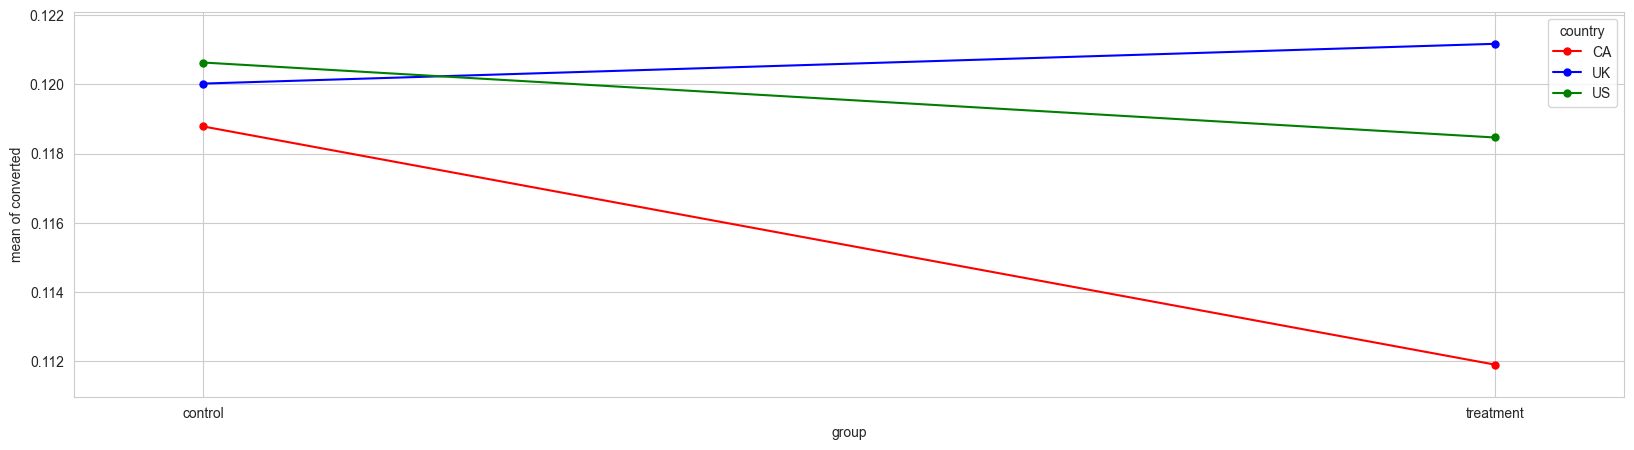

In [31]:
fig = interaction_plot(x=df3.group, trace=df3.country, response=df3.converted, colors=['red','blue','green'], ms=10)

In [32]:
aov = pg.anova(dv="converted", between=["group","country"], data=df3, detailed=True)
print(aov)

            Source            SS        DF        MS         F     p-unc  \
0            group      0.180029       1.0  0.180029  1.709797  0.191013   
1          country      0.336956       2.0  0.168478  1.600092  0.201880   
2  group * country      0.254205       2.0  0.127102  1.207132  0.299055   
3         Residual  30595.884432  290579.0  0.105293       NaN       NaN   

        np2  
0  0.000006  
1  0.000011  
2  0.000008  
3       NaN  


Output Explanation:
- `Source`: This column lists the sources of variation, including the main effects (group and country), the interaction effect (group * country), and the residuals.
- `SS` (Sum of Squares): This represents the sum of squared deviations for each source of variation.
- `DF` (Degrees of Freedom): This represents the degrees of freedom associated with each source of variation.
- `MS` (Mean Squares): This is the sum of squares divided by the corresponding degrees of freedom (SS/DF).
- `F` (F-statistic): This is the ratio of the mean square of the source to the mean square of the residuals.
- `p-unc` (Uncorrected p-value): This is the p-value associated with the F-statistic, used to determine statistical significance.
- `np2` (Partial eta-squared): This is a measure of effect size for each source of variation.

Interpretation of the Results:
#### Group Effect:
- **F-statistic**: 1.709797
- **p-value**: 0.191013
- **Interpretation**: Since the p-value (0.191) is greater than the significance level (0.05), we fail to reject the null hypothesis for the group effect. This suggests that there is no significant difference in conversion rates between the control and treatment groups.

#### Country Effect:
- **F-statistic**: 1.600092
- **p-value**: 0.201880
- **Interpretation**: The p-value (0.2019) is greater than 0.05, indicating that there is no significant difference in conversion rates between countries (USA and UK).

#### Interaction Effect (Group * Country):
- **F-statistic**: 1.207132
- **p-value**: 0.299055
- **Interpretation**: The p-value (0.2991) is greater than 0.05, suggesting that there is no significant interaction effect between group and country. This means that the difference in conversion rates between the control and treatment groups does not depend on the country.

#### Summary:
- Main Effects: Neither the group effect nor the country effect is statistically significant, as indicated by their p-values being greater than 0.05.
- Interaction Effect: The interaction between group and country is also not statistically significant.

Our analysis suggests that there are no significant differences in conversion rates based on the group (control vs. treatment), country (USA vs. UK), or their interaction. This means that the treatment did not have a statistically significant effect on conversion rates, and this effect was consistent across different countries.

### A/B Testing on a continous metric

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

`userid` - a unique number that identifies each player.

`version` - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40). When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

`sum_gamerounds` - the number of game rounds played by the player during the first week after installation

`retention_1` - did the player come back and play 1 day after installing?

`retention_7` - did the player come back and play 7 days after installing?


In [33]:
df4 = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/A:B Testing//cookie_cats.csv")
df4.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [34]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [35]:
# Check duplicated row & userid
print(df4.duplicated().any())
print(df4["userid"].duplicated().any())

False
False


In [36]:
# goupby version & summary stats
df4.groupby("version").sum_gamerounds.agg(["count","min","max","mean","median","std"])

,count,min,max,mean,median,std
version,,,,,,
gate_30,44700,0,49854,52.456264,17.0,256.716423
gate_40,45489,0,2640,51.298776,16.0,103.294416


In [37]:
# Split the data by version
df_30 = df4[df4.version == "gate_30"]
df_40 = df4[df4.version == "gate_40"]

# Calculate summary statistics for the entire dataset
stat_total = df4[["sum_gamerounds"]].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

# Calculate summary statistics for the gate_30 version
stat_30 = df_30[["sum_gamerounds"]].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

# Calculate summary statistics for the gate_40 version
stat_40 = df_40[["sum_gamerounds"]].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

# Concatenate the results into a single DataFrame
summary_stat = pd.concat([stat_total, stat_30, stat_40], keys=["stat_total", "stat_30", "stat_40"])

In [38]:
summary_stat

,,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
stat_total,sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,5.0,16.0,51.0,134.0,221.0,493.00,49854.0
stat_30,sum_gamerounds,44700.0,52.456264,256.716423,0.0,0.0,1.0,1.0,5.0,17.0,50.0,135.0,222.0,493.00,49854.0
stat_40,sum_gamerounds,45489.0,51.298776,103.294416,0.0,0.0,1.0,1.0,5.0,16.0,52.0,134.0,220.0,492.12,2640.0


<Axes: xlabel='index'>

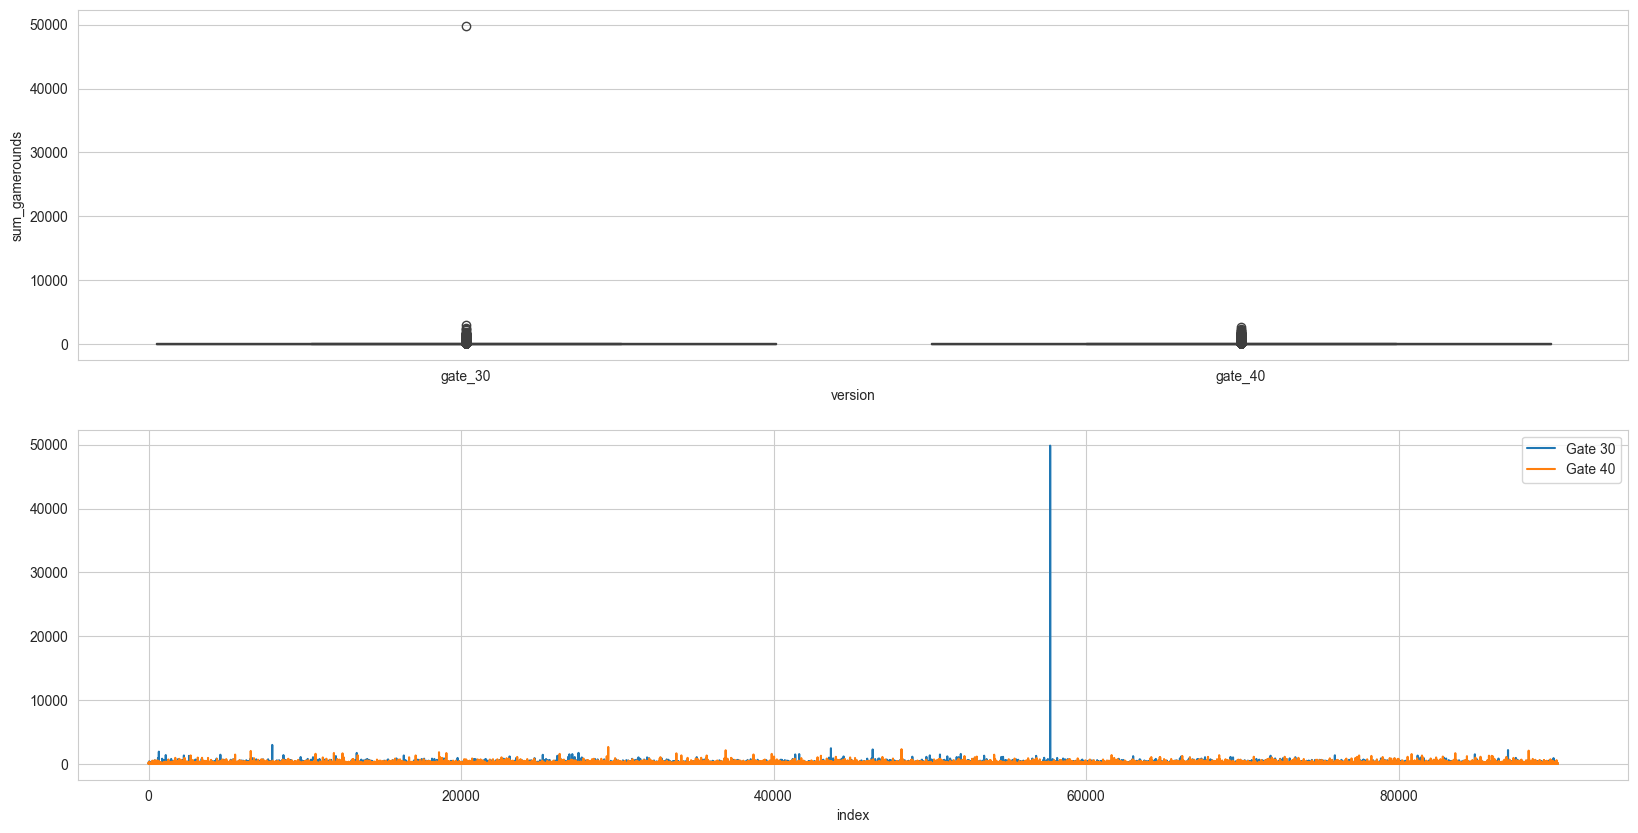

In [39]:
fig, axes = plt.subplots(2,figsize=(20,10))
sns.boxplot(x=df4.version, y=df4.sum_gamerounds, ax=axes[0])

df_30.reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30",ax=axes[1])
df_40.reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40",ax=axes[1])

#### Detect and Remove Outerliers

Standard Deviation Method: used for Gaussian or Gaussian-like data. Onew Standard Deviation from the Mean will cover 68 percent, two Standard Deviations from the Mean will cover 95 percent, and three Standard Deviations from the Mean will cover 99.7 percent.Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95 percent) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9 percent) can be used.

Interquartile Range Method (IQR): used for a non-Gaussian distribution. The IQR can then be calculated as the difference between the 75th and 25th percentiles. A factor k of the IQR below the 25th percentile or above the 75th percentilebe is used to identify outliers. The common valuefor the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers.

In [40]:
def outlier_detected(data):
    q25, q75 = np.percentile(data.sum_gamerounds, 25), np.percentile(data.sum_gamerounds, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 4
    lower, upper = q25 - cut_off, q75 + cut_off
    print("25th = %.2f, 75th = %.2f, IQR = %.2f, Lower = %.2f, Upper = %.2f" % (q25, q75, iqr, lower, upper))
    
    # identify outliers
    outliers = data[(data.sum_gamerounds < lower) | (data.sum_gamerounds > upper)]
    print("The number of Identified outliers: %d" % len(outliers))
    
    outliers_removed = data[(data.sum_gamerounds >= lower) & (data.sum_gamerounds <= upper)]
    print("Percent of outliers: %.2f%%" % (100 * (1 - len(outliers_removed) / len(data))))
    
    return outliers_removed

df_c30 = outlier_detected(df_30)


25th = 5.00, 75th = 50.00, IQR = 45.00, Lower = -175.00, Upper = 230.00
The number of Identified outliers: 2085
Percent of outliers: 4.66%


In [41]:
df_c40 =  outlier_detected(df_40) 

25th = 5.00, 75th = 52.00, IQR = 47.00, Lower = -183.00, Upper = 240.00
The number of Identified outliers: 1963
Percent of outliers: 4.32%


In [42]:
df_clean = outlier_detected(df4) 

25th = 5.00, 75th = 51.00, IQR = 46.00, Lower = -179.00, Upper = 235.00
The number of Identified outliers: 4073
Percent of outliers: 4.52%


In this case, IQR method is not very well. Whether we directly remove outliers from the total data, or respectively remove outlier from two versions, the percentages of the removed outliers from the two versions will be different since the spreads and centers of their sum_gameground are not the same. This might affect the testing result.

Let's do more analysis on some details. From the statistic summary, we notice that the distribution of the sum_gamerounds data is exponential-like, which centers in a small range with a long right tail. About 50 percent of the total sum_gamerounds is the values between 5 and around 50. As the values of the sum_gamerounds increase, the counts of the sum_gramerounds decrease dramatically. The values of the last 5 percent and 1 percent of the data are respectively larger than 220 and 492. How to choose the cutoff of the outliers might affect our test result. Therefore, it is better for us to list all of the testing results with the relevant outlier percentage. Then, the product development or other relevant development can make a decision depending on their concern.

In [43]:
def outlier_removed(data1, data2, quantile_threshold):
    # Remove outliers based on the quantile threshold
    dc_1 = data1[data1.sum_gamerounds <= data1.sum_gamerounds.quantile(quantile_threshold)]
    dc_2 = data2[data2.sum_gamerounds <= data2.sum_gamerounds.quantile(quantile_threshold)]
    
    # Concatenate the cleaned data
    dc = pd.concat([dc_1, dc_2])
    
    # Calculate the percentage of outliers removed
    total_data_len = len(data1) + len(data2)
    percent_outliers = 100 * (1 - len(dc) / total_data_len)
    print("Percent of outliers: %.2f%%" % percent_outliers)
    
    return dc

# Assuming df_mg is the combined dataset before removing outliers
data_clean = outlier_removed(df_30, df_40, 0.95)


Percent of outliers: 4.98%


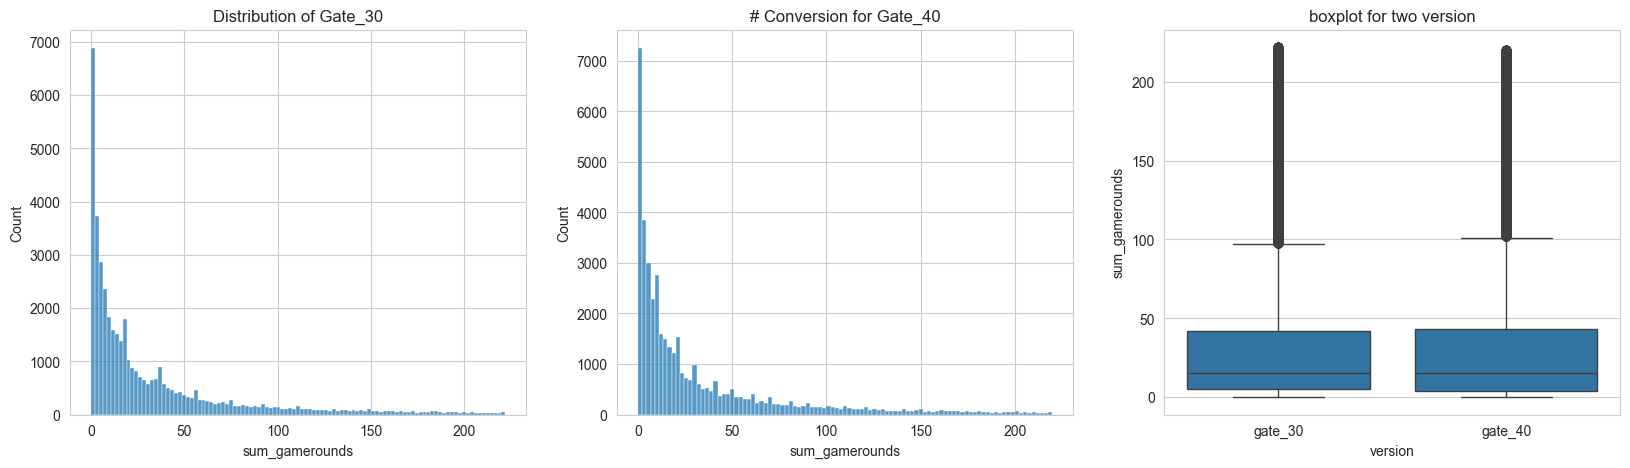

In [44]:
fig, axes = plt.subplots(1,3)

sns.histplot(x="sum_gamerounds", data=data_clean[data_clean.version=="gate_30"], ax=axes[0])
axes[0].set_title("Distribution of Gate_30")

sns.histplot(x="sum_gamerounds", data=data_clean[data_clean.version=="gate_40"],ax=axes[1])
axes[1].set(title="# Conversion for Gate_40")

sns.boxplot(x=data_clean.version, y=data_clean.sum_gamerounds, ax=axes[2])
axes[2].set(title="boxplot for two version")

plt.show()

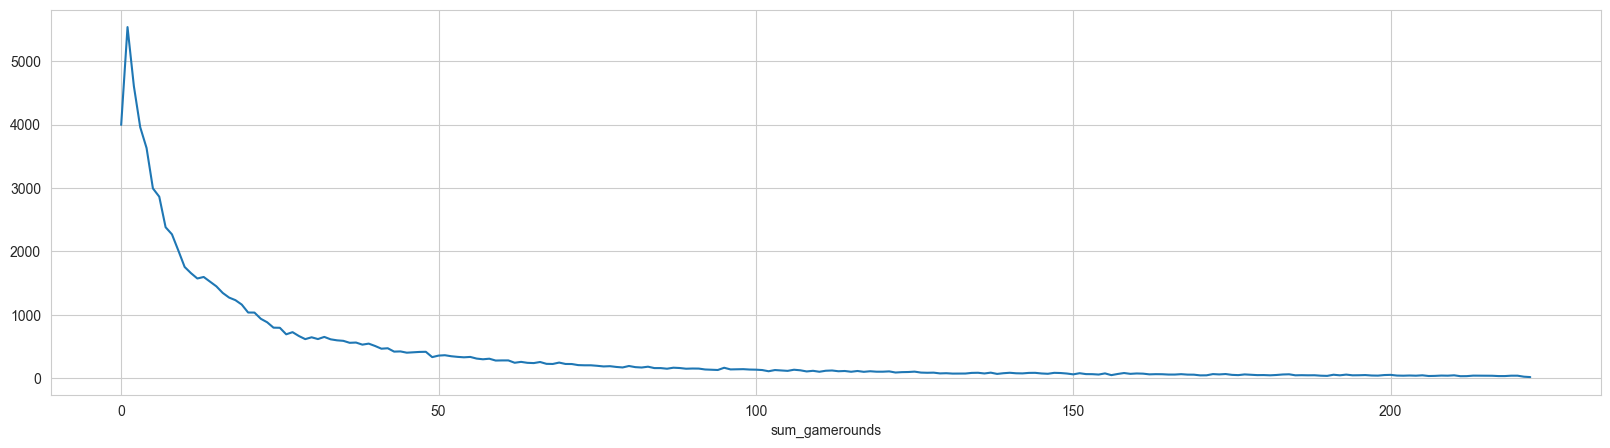

In [45]:
data_clean.groupby("sum_gamerounds").userid.count().plot()
plt.show()

In [46]:
counts = data_clean.groupby("sum_gamerounds").userid.count().reset_index()
counts[counts["userid"]==counts.userid.max()]

,sum_gamerounds,userid
1,1,5538


In [47]:
# Summary statistics for the cleaned data
df_clean_30 = data_clean[data_clean.version == "gate_30"]
df_clean_40 = data_clean[data_clean.version == "gate_40"]

# Summary statistics for the entire cleaned dataset
stat_clean_total = data_clean[["sum_gamerounds"]].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

# Summary statistics for the cleaned 'gate_30' version
stat_clean_30 = df_clean_30[["sum_gamerounds"]].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

# Summary statistics for the cleaned 'gate_40' version
stat_clean_40 = df_clean_40[["sum_gamerounds"]].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

# Concatenate the results into a single DataFrame
summary_clean_stat = pd.concat([stat_clean_total, stat_clean_30, stat_clean_40], keys=["stat_clean_total", "stat_clean_30", "stat_clean_40"])

In [48]:
summary_clean_stat

,,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
stat_clean_total,sum_gamerounds,85702.0,33.162225,44.095410,0.0,0.0,1.0,1.0,4.0,15.0,43.0,96.0,138.0,198.0,222.0
stat_clean_30,sum_gamerounds,42477.0,33.233821,44.134720,0.0,0.0,1.0,1.0,5.0,15.0,42.0,95.0,138.0,199.0,222.0
stat_clean_40,sum_gamerounds,43225.0,33.091868,44.057144,0.0,0.0,1.0,1.0,4.0,15.0,43.0,96.0,137.0,197.0,220.0


#### A/B Testing on a continous metric: sum_gamerounds

As shown in the decision tree at the beginning of this notebook, we need to do two tests first to make A/B testing successful.

- Using the Shapiro-Wilk test to check if each group was drawn from a normal distribution.

- If Normal distribution, Using Levene's test to check if k samples have equal variances (Homogeneity of variances).

- If Normal & homogeneity, apply T-test.

- If Normal but non-homogeneity, apply Welch Test

- If Non-Normal, apply Mann Whitney U Test.

In [49]:

#from scipy.stats import shapiro

def AB_Test(dataframe, group, metric):

    # Split A/B
    groupA = dataframe[dataframe[group] == "gate_30"][metric]
    groupB = dataframe[dataframe[group] == "gate_40"][metric]
    
    # The Shapiro-Wilk test: Normality
    # H0: Distribution is Normal! - p_value > 0.05  
    # H1: Distribution is not Normal! - p_value < 0.05
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    if (ntA == False) & (ntB == False): # Both groups are from normal distributions
        # Normal distribution
        # The Levene test: Equality of variances
        # H0: Homogeneity: - p_value > 0.05 
        # H1: Heterogeneity: - p_value < 0.05
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
        if leveneTest == False: # Homogeneity of variances
            # t-test: Equality of means
            # H0: MA == MB 
            # H1: MA != MB 
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        else: # Heterogeneity of variances
            # H0: MA == MB 
            # H1: MA != MB 
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        # Non-Normal distributions
        # H0: MA == MB 
        # H1: MA != MB 
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Distribution"] = np.where((ntA == False) & (ntB == False), "Normal", "Non-Normal")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0") 
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Distribution", "Homogeneity", "p-value", "AB Hypothesis", "Comment"]]
    else:
        temp = temp[["Distribution", "p-value", "AB Hypothesis", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

In [50]:
# Apply A/B Testing, outlier cutoff is 95%
AB_Test(dataframe=data_clean, group = "version", metric = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Distribution,p-value,AB Hypothesis,Comment
0,Non-Normal,0.034768,Reject H0,A/B groups are not similar!


In [51]:
# Try cutoff is 99%
data_clean_99 =  outlier_removed(df_30,df_40, 0.99)
# Apply A/B Testing
AB_Test(dataframe=data_clean_99, group = "version", metric = "sum_gamerounds")

Percent of outliers: 1.00%
# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Distribution,p-value,AB Hypothesis,Comment
0,Non-Normal,0.045968,Reject H0,A/B groups are not similar!


In [52]:
# Try non outliers removed 
AB_Test(dataframe=df4, group = "version", metric = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Distribution,p-value,AB Hypothesis,Comment
0,Non-Normal,0.050209,Fail to Reject H0,A/B groups are similar!


#### A/B Testing on discrete metric: retention_1,retention_7

In [53]:
# Define A/B groups
data_clean["version"] = np.where(data_clean.version == "gate_30", "control", "treatment")

In [54]:
# Apply A/B Testing
AB_testing(dataframe=data_clean, group = "version", metric = "retention_1")

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.072218,Fail to Reject H0,A/B groups are similar!


In [55]:
# Apply A/B Testing
AB_testing(dataframe=data_clean, group = "version", metric = "retention_7")

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.000371,Reject H0,A/B groups are not similar!
